<div align="center"><img src="../images/LKYCIC_Header.jpg"></div>

**Table of contents**<a id='toc0_'></a>    
- [2-03: Network Analysis](#toc1_)    
  - [Part of a Project](#toc1_1_)    
  - [Data](#toc1_2_)    
    - [Use OSMnx to get street networks](#toc1_2_1_)    
      - [Query/download place boundaries](#toc1_2_1_1_)    
      - [Query the data using the boundary](#toc1_2_1_2_)    
    - [Export the roadset to GeoJSON](#toc1_2_2_)    
    - [Import other dataset](#toc1_2_3_)    
  - [Types of Distances](#toc1_3_)    
  - [Network Distance Calculation](#toc1_4_)    
    - [Preprcossing the Graph of Network](#toc1_4_1_)    
    - [Origin-Destination Network Distance](#toc1_4_2_)    
  - [Batch Calculation of Network Distance](#toc1_5_)    
    - [Calculating for each Hawker Centre](#toc1_5_1_)    
  - [Wrap up for second section](#toc1_6_)    
  - [Next Section](#toc1_7_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

# <a id='toc1_'></a>[2-03: Network Analysis](#toc0_)

Networks can represent geographic, real-world, or social systems. 

This section will focus on analysing **accessibility** through network analysis. 

## <a id='toc1_1_'></a>[Part of a Project](#toc0_)

This section will be project based. The topic of the project is **Assessing Connectiveness of MRT stations of Hawker Centres in Singapore**.

## <a id='toc1_2_'></a>[Data](#toc0_)

1. Hawker Centre Data:

   - Source: NEA

   - Attributes needed:

     - Geometry

     - Number of stalls

2. MRT Data:

   - Source: OpenDataSG

   - Attributes needed:
      
      - Geometry

3. **Road Network Data**:

   - Source: OpenStreetMap; We will download it by using **[OSMnx](https://osmnx.readthedocs.io/en/stable/)**

   - Attributes needed:
      
      - Geometry

### <a id='toc1_2_1_'></a>[Use OSMnx to get street networks](#toc0_)

In [ ]:
# Uncomment the following line to install osmnx
#!pip install osmnx

In [1]:
import osmnx as ox
import networkx as nx

ox.__version__

'2.0.1'

#### <a id='toc1_2_1_1_'></a>[Query/download place boundaries](#toc0_)

`ox.geocoder.geocode_to_gdf` retrieve the geometry of a place from the Nominatim geocoding API and return it as a GeoDataFrame.

In this case, we will retrieve the geometry of **Tampines**.

<Axes: >

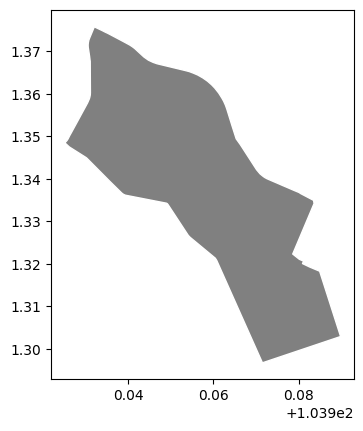

In [2]:
# neighborhoods or boroughs
tampines_gdf = ox.geocoder.geocode_to_gdf("Tampines, Singapore")

tampines_gdf.plot(fc="gray", ec="w")

In [3]:
tampines_gdf.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

`ox.utils_geo.buffer_geometry` will buffer an unprojected Shapely geometry by some distance in meters.

In [ ]:
tampines_buffer = ox.utils_geo.buffer_geometry(tampines_gdf.iloc[0]["geometry"], 500)

In [ ]:
tampines_buffer.plot(fc="gray", ec="w")

The error messege says "AttributeError: 'Polygon' object has no attribute 'plot'"

In [ ]:
type(tampines_buffer)

Only `GeoDataFrame` has `.plot()` function. For a Polygon object, you need to use the Matplotlib library to plot it. 

In [ ]:
tampines_buffer

You can also use the `matplotlib.pyplot` module to create a plot by extracting the coordinates of the Polygon.

In [ ]:
from matplotlib import pyplot as plt

x, y = tampines_buffer.exterior.xy

plt.plot(x, y, color="red")

# Equivalent syntax: plt.plot(*tampines_buffer.exterior.xy, color="red")
# The * operator unpacks the tuple returned by tampines_buffer.exterior.xy

#### <a id='toc1_2_1_2_'></a>[Query the data using the boundary](#toc0_)

The `graph_from_polygon` function downloads and creates a graph within the boundaries of a (Multi)Polygon.

In [ ]:
G = ox.graph.graph_from_polygon(tampines_buffer, network_type="walk", simplify=False, retain_all=True)
# retain_all=True means we'll keep all the disconnected graph components
# simplify=False means we won't simplify the graph topology

In [ ]:
# We can use the plot_graph function provided by OSMnx to plot the graph
fig, ax = ox.plot.plot_graph(G, node_size=5, edge_color="yellow", edge_linewidth=0.25)

In addition to a polygon of the desired street network's boundaries (The Tampines, Singapore buffered polygon)

You can download a street network by providing OSMnx any of the following:

- a bounding box

- a lat-long point plus a distance

- an address plus a distance

- a place name or list of place names

### <a id='toc1_2_2_'></a>[Export the roadset to GeoJSON](#toc0_)

Firstly, we need to use `ox.convert.graph_to_gdfs` to transform it (NetworkX graph object) to GeoDataFrame.

In [ ]:
tampines_road = ox.convert.graph_to_gdfs(G, nodes=True, edges=True, node_geometry=True, fill_edge_geometry=True)

In [ ]:
print(type(tampines_road))
print(len(tampines_road))

In [ ]:
tampines_road[0].head() # G.nodes

In [ ]:
tampines_road[1].head() # G.edges

We can see that it is a tuple (a variable contains multiple GeoDataFrame):

1. The first GeoDataFrame is <u>Point data</u> (Facilities, Infrastructure, etc.)

2. The second one is <u>Line data</u> (The Road Network data)

> Tuples are used to store multiple items in a single variable.

In [ ]:
# export the graph to disk as a shapefile
tampines_road[1].to_file("../data/tampines_road.geojson", driver="GeoJSON") # G.edges

At this time, we have acquired the road network in Tampines.

You can customise your data using avaliable tags.

For example, for **covered road in Tampines**:

we can use the tag `covered`, where the value is set to `true`:

`["covered"="yes"]`

Reference:

https://wiki.openstreetmap.org/wiki/Add_sheltered_walkways_in_Singapore

We can define our own fine-tuned network type using OSMnx's `custom_filter` parameter (to get just highways, or railways, canals, etc)：

In [ ]:
custom_filter = '["covered"="yes"]' # only keep covered ways
G_covered = ox.graph.graph_from_polygon(
    tampines_buffer,
    custom_filter=custom_filter,
    simplify=False,
    retain_all=True
)

# We can use the plot_graph function provided by OSMnx to plot the graph
fig, ax = ox.plot.plot_graph(G_covered, node_size=0, edge_color="#FFFF5C", edge_linewidth=0.25) 

### <a id='toc1_2_3_'></a>[Import other dataset](#toc0_)

1. Hawker Centre Data: `../data/raw/project/hc_points_cleaned.geojson`

2. MRT Data: `../data/processed/part_ii/mrt_sg/MRT_LRT_Stations.shp`

`Challenge 1`: Read the above two files as GeoDataFrame and a quick plot

In [ ]:
import geopandas as gpd

Read the data:

In [ ]:
#————————————————————————————————————————————————————————————————————————————————#
hc_sg = #———————————————————————————————————————————————————————————#
mrt_sg = #———————————————————————————————————————————————————————————#
hc_sg.plot()
mrt_sg.plot()
#————————————————————————————————————————————————————————————————————————————————#

In [ ]:
# use the tampines_buffer to extract
hc_tampines = hc_sg[hc_sg.within(tampines_buffer)]

hc_tampines.plot()

In [ ]:
# use the tampines_buffer to extract
mrt_tampines = mrt_sg[mrt_sg.within(tampines_buffer)]

mrt_tampines.plot()

`Task`: Calculate the nearest MRT station and Hawker centre from SUTD based on road network distance?

## <a id='toc1_3_'></a>[Types of Distances](#toc0_)

<div align="center">
    <img src="../images/different_type_distances.jpg" width=500px>
    <br>Different Type of Distance
    <br>Source: 10.1186/1476-072X-7-7
</div>

## <a id='toc1_4_'></a>[Network Distance Calculation](#toc0_)

### <a id='toc1_4_1_'></a>[Preprcossing the Graph of Network](#toc0_)

In [ ]:
# Step 1: Project the graph to UTM
G_projected = ox.project_graph(G)

projected_crs = G_projected.graph['crs']

projected_crs

In [ ]:
# Remove all the nodes because the original nodes is the facilities in Singapore
# the current nodes will be the edge nodes and intersection nodes of roads
G_projected = ox.simplification.simplify_graph(G_projected)

In [ ]:
hc_tampines_projected = hc_tampines.to_crs(projected_crs)

mrt_tampines_projected = mrt_tampines.to_crs(projected_crs)

### <a id='toc1_4_2_'></a>[Origin-Destination Network Distance](#toc0_)

`Task`: Find the nearest MRT station to SUTD and the route from the SUTD to the MRT station.

In [ ]:
# SUTD coordinate is 1.3407454955903624, 103.96232069964708
sutd = [103.96232069964708, 1.3407454955903624] # lng and lat pair

For a longitude and latitude pair, additional steps are required to project it because it is not a geographic object but simply a list containing two numbers.

We can use the following code to convert it to the specified CRS

In [ ]:
from pyproj import Transformer

In [ ]:
# Define transformer from WGS 84 (EPSG 4326) to the projected CRS
transformer = Transformer.from_crs("EPSG:4326", projected_crs, always_xy=True)

# Transform the coordinates
x, y = transformer.transform(sutd[0], sutd[1])  # Note: pyproj uses (lon, lat) order

print(f"Projected coordinates: X={x}, Y={y}")

OSMnx and NetworkX calculate distance based on nodes in the graph.

Take the SUTD as origin, we use `ox.distance.nearest_nodes()` to find the nearest node in the map to the origin.

In [ ]:
# Step 2: Find the nearest node to the origin point
origin_node = ox.distance.nearest_nodes(G_projected, X=x, Y=y)

ox.plot_graph_route(G_projected, [origin_node])

In [ ]:
for index, row in mrt_tampines_projected.iterrows():
    x, y = row["geometry"].x, row["geometry"].y # lng and lat pair
    nearest_node = ox.distance.nearest_nodes(G_projected, X=x, Y=y) # find the nearest node
    mrt_tampines_projected.at[index, "nearest_node"] = nearest_node # store the nearest node

mrt_tampines_projected.head()

In [ ]:
for index, row in mrt_tampines_projected.iterrows():
    x, y = row["geometry"].x, row["geometry"].y
    nearest_node = ox.distance.nearest_nodes(G_projected, X=x, Y=y)
    mrt_tampines_projected.at[index, "nearest_node"] = nearest_node
     
    try:
        '''
        Find the shortest path length between the origin node and the nearest node
        '''
        distance = nx.shortest_path_length(
            G_projected, source=origin_node, target=nearest_node, weight="length"
        )
        mrt_tampines_projected.at[index, "distance"] = distance # store the distance
    except nx.NetworkXNoPath:
        '''
        If there is no path between the origin node and the nearest node
        '''
        mrt_tampines_projected.at[index, "distance"] = None

mrt_tampines_projected.head()

Sort the dataframe by distance:

In [ ]:
mrt_tampines_projected.sort_values("distance", ascending=True, inplace= True)

mrt_tampines_projected.head()

Get the name of the closest MRT station:

In [ ]:
cloest_mrt = mrt_tampines_projected.iloc[0]['Name'] 

print(f"The closest MRT station to SUTD is {cloest_mrt}")

Get the index of the nearest node

In [ ]:
cloest_mrt_node = int(mrt_tampines_projected.iloc[0]['nearest_node'])

cloest_mrt_node

Find the shortest path

In [ ]:
shortest_path = nx.shortest_path(G_projected, origin_node, cloest_mrt_node, weight="length") 

shortest_path

In [ ]:
ox.plot_graph_route(G_projected, shortest_path)

## <a id='toc1_5_'></a>[Batch Calculation of Network Distance](#toc0_)

### <a id='toc1_5_1_'></a>[Calculating for each Hawker Centre](#toc0_)

In [ ]:
for index, row in hc_tampines_projected.iterrows():
    x, y = row["geometry"].x, row["geometry"].y
    nearest_node = ox.distance.nearest_nodes(G_projected, X=x, Y=y)
    hc_tampines_projected.at[index, "nearest_node"] = nearest_node

hc_tampines_projected

In [ ]:
for index1, hc in hc_tampines_projected.iterrows():
    node_hc = hc["nearest_node"]
    distance = {}
    for index2, mrt in mrt_tampines_projected.iterrows():
        node_mrt = mrt["nearest_node"]
        mrt_name = mrt["Name"]
        dist = nx.shortest_path_length(G_projected, source=node_hc, target=node_mrt, weight="length")
        distance[mrt_name] = dist
    nearest_mrt = min(distance, key=distance.get)
    nearest_mrt_dist = distance[nearest_mrt]

    hc_tampines_projected.at[index1, "nearest_mrt"] = nearest_mrt
    hc_tampines_projected.at[index1, "nearest_mrt_dist"] = nearest_mrt_dist

In [ ]:
hc_tampines_projected

## <a id='toc1_6_'></a>[Wrap up for second section](#toc0_)

We learned about the three most common types of geospatial data: **vector, raster, and network**, and how to process them in Python.

Each type of data has a prominent package commonly used for processing:

- For vector data, it is **GeoPandas**.  
- For raster data, it is **Rasterio**.  
- For network data, it is **NetworkX**.  

When using these packages in your data processing workflows, you may encounter situations where their built-in functions do not fully meet your needs. In such cases, make good use of resources like Google, Stack Overflow and AI tools to explore existing solutions or determine if you need to write custom code from scratch.

**Note:** 

When working with different types of data and pursuing various research objectives, there is an abundance of packages available to suit your needs. 

The selection of the appropriate tools depends on the specific requirements of your analysis and goals.  

As we move into the second session, the coding content becomes more intensive. However, there’s no need to memorise every detail or command. 

In practice, you will always have access to the internet, which serves as an invaluable resource for exploring documentation, tutorials, and examples. 

Focus on understanding the core concepts and workflows—these will empower you to confidently tackle real-world challenges, regardless of the tools or packages involved.

## <a id='toc1_7_'></a>[Next Section](#toc0_)

Please bring one point data type file of your own to the class tomorrow!

We will create a static and interactive map based on the data.

Go to [3-01: Geospatial Data Wrangling](./3-01_datawrangling_geo.ipynb)